In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score,StratifiedKFold
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from collections import Counter
from sklearn.metrics import accuracy_score, roc_curve, auc,confusion_matrix,ConfusionMatrixDisplay,f1_score,recall_score,precision_score
import pickle
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from skopt import BayesSearchCV
from skopt.callbacks import DeltaYStopper


In [2]:
data = pd.read_csv("/kaggle/input/cats-project/CATS_data.csv",index_col= None)

In [3]:
data

,Subgroup,1,2,3,4,5,6,7,8,9,...,2825,2826,2827,2828,2829,2830,2831,2832,2833,2834
0,HER2+,0,0,0,0,0,0,0,0,0,...,1,1,0,1,1,1,1,1,1,1
1,HR+,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
2,HR+,0,0,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
3,Triple Neg,0,0,0,0,-1,-1,-1,0,-1,...,1,1,1,1,1,1,1,1,1,1
4,Triple Neg,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Triple Neg,0,0,1,1,1,1,1,1,0,...,1,1,1,1,1,1,1,1,1,1
96,HR+,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
97,HR+,1,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
98,HR+,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1


In [4]:
y = data.Subgroup
x = data.drop('Subgroup',axis=1)

In [5]:
y.value_counts()

Subgroup
HR+           36
HER2+         32
Triple Neg    32
Name: count, dtype: int64

In [6]:
clf= RandomForestClassifier()


In [7]:
#define the pipeline, I used recursive feature elimination for feature selection. For different feature selection methods you can use 'SelectKBest' instead of RFE, check the documentation of sklearn for instruction
#you can change the 'model' from LinearSVC to other sklearn models
pipe = Pipeline(steps=[('feat_sel', RFE(estimator= RandomForestClassifier(),step=100)),
                       ('model', RandomForestClassifier())])

In [8]:
#Creating a Bayesian search class that stops after it converges (delta)
class BayesSearchCVWithStopper(BayesSearchCV):
    def __init__(self, estimator, search_spaces, cv, n_jobs, n_iter=50, delta=0.01, n_best=5):
        # Fixing the n_iter default and handling argument passing
        super().__init__(estimator=estimator, search_spaces=search_spaces, cv=cv, n_jobs=n_jobs, n_iter=n_iter)
        self.delta = delta
        self.n_best = n_best
        

        
        
    def fit(self, X, y=None, **fit_params):
        return super().fit(X, y, callback=[DeltaYStopper(delta = self.delta,n_best = self.n_best)], **fit_params)

In [9]:
%%time
#nested cv to estimate the test performance of our training pipeline, repeated 100 times, outer 3-fold cv, inner 5-fold cv
test_score_nested = []
N_TRIALS = 10
param_grid = {
    'feat_sel__n_features_to_select': [ 10, 20, 30, 40, 50,75],
    'model__max_depth': list(range(5, 51)),
    'model__criterion': ['gini'],
    'model__min_samples_leaf': list(range(1, 73, 2)),
    'model__max_features': ['sqrt', 'log2'],
    'model__n_estimators': list(range(5, 100, 5))
}
for i in range(N_TRIALS):  
    inner_cv = StratifiedKFold(5,shuffle=True, random_state=i)
    outer_cv = StratifiedKFold(3,shuffle=True, random_state=i)
    search = BayesSearchCV(estimator = pipe, search_spaces=param_grid,cv=inner_cv,n_jobs=-1, n_iter = 50)
    test_score = cross_val_score(search, x, y, cv=outer_cv, n_jobs=-1)
    test_score_nested.append(test_score.mean())
    print(test_score.mean())

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):


0.7103386809269162
0.7287581699346405


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  

0.7397504456327986
0.7299465240641712


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension

0.6491384432560903
0.8291740938799762


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension

0.7691622103386809
0.7106357694592988
0.7094474153297683


/usr/local/lib/python3.11/dist-packages/pandas/core/algorithms.py:1743: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)


0.7115270350564469
CPU times: user 1min 26s, sys: 46.8 s, total: 2min 13s
Wall time: 9h 1min 11s


In [10]:
test_score_nested

[0.7103386809269162,
 0.7287581699346405,
 0.7397504456327986,
 0.7299465240641712,
 0.6491384432560903,
 0.8291740938799762,
 0.7691622103386809,
 0.7106357694592988,
 0.7094474153297683,
 0.7115270350564469]

In [11]:
scores=pd.DataFrame(test_score_nested)

<Axes: >

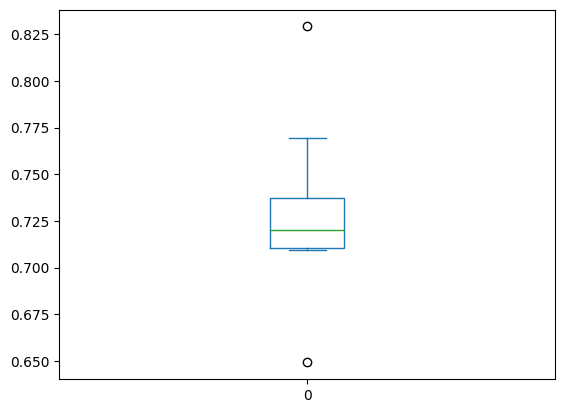

In [12]:
scores.plot.box()
